# Notebook to test optimization routine - examine single trace

In [1]:
import marsis.mcmichael
from marsis.util import trigDelay, refChirp, baseBand, pulseCompressTrig
import marsis.edr
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize

In [2]:
edr = marsis.edr.EDR("/home/mchristo/proj/orbitRadar/mar-proc/testData/e_08700_ss3_trk_cmp_m.lbl")
sim = np.fromfile("/home/mchristo/proj/simc/out/marsis/e_08700_ss3_trk_cmp_m_g_combined.img", dtype=np.float32).reshape(edr.data["ZERO_F1"].shape)

In [4]:
dlyF1, dlyF2 = trigDelay(edr)
bands = [1.8e6, 3e6, 4e6, 5e6]

In [244]:
i = 500
TRACE = edr.data["ZERO_F1"][:,i]
simt = sim[:,i]
dly = dlyF1[i]
band = bands[edr.ost["DCG_CONFIGURATION_F1"][i]]
dlyBound = 5
steps = 50
suspDelay = 22

In [243]:
print(totalDelay([psis[0][foc[0]], psis[1][foc[1]], psis[2][foc[2]]], band))

[21.89473684]


In [248]:
#x0 = [0,0,0]
x0 = np.array([psis[0][foc[0]], psis[1][foc[1]], psis[2][foc[2]]])

#opt = scipy.optimize.minimize(obj_func, x0, args=(TRACE, dly, band, simt), method="BFGS", options={"disp": True, "return_all": True, "gtol":1e-1, "eps": 1e2})
opt = scipy.optimize.minimize(obj_func, x0, args=(TRACE, dly, band, simt), method="L-BFGS-B", options={"eps":1e2, "gtol":1e-12, "disp":False}, bounds=((0, None), (0, None), (0, None)))
print(x0.T)
print(opt.x)
print(opt)
print(obj_func(x0, TRACE, dly, band, simt))
print(obj_func(opt.x, TRACE, dly, band, simt))

/tmp/ipykernel_199640/1682510246.py:5: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  opt = scipy.optimize.minimize(obj_func, x0, args=(TRACE, dly, band, simt), method="L-BFGS-B", options={"eps":1e2, "gtol":1e-12, "disp":False}, bounds=((0, None), (0, None), (0, None)))


[[1.32893157e+09 0.00000000e+00 0.00000000e+00]]
[1.21449326e+09 1.89418365e+07 0.00000000e+00]
  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: -9285076122.313763
        x: [ 1.214e+09  1.894e+07  0.000e+00]
      nit: 19
      jac: [-1.074e-03 -5.070e-03  2.373e+01]
     nfev: 248
     njev: 62
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
-8953611924.99974
-9285076122.313673


/tmp/ipykernel_199640/2981537533.py:5: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(psis[2], psis[1], np.log(np.abs(img0)).reshape((steps, steps)))
/tmp/ipykernel_199640/2981537533.py:14: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(psis[2], psis[0], np.log(np.abs(img1)).reshape((steps, steps)))
/tmp/ipykernel_199640/2981537533.py:23: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(psis[1], psis[0], np.log(np.abs(img2)).reshape((steps, steps)))


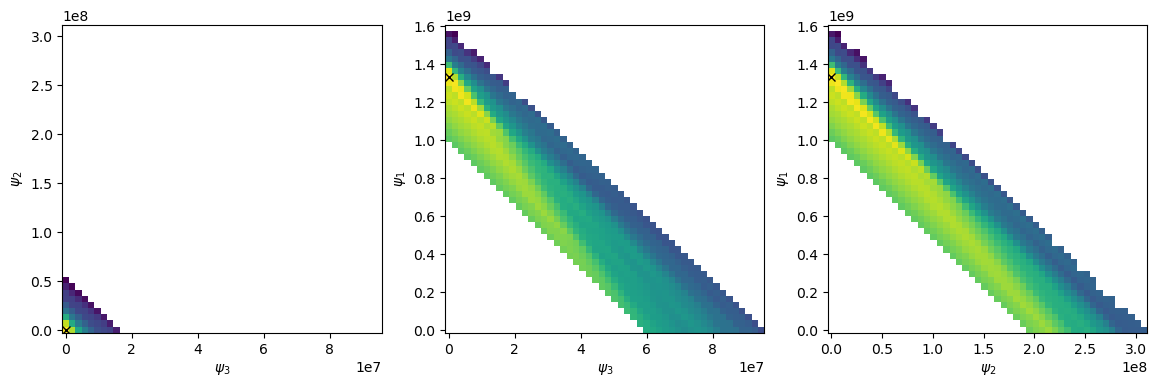

In [247]:
plopt = False

plt.figure(figsize=(14, 4))
plt.subplot(1,3,1)
plt.pcolormesh(psis[2], psis[1], np.log(np.abs(img0)).reshape((steps, steps)))
if(plopt):
    for pt in opt.allvecs:
        plt.plot(pt[2], pt[1], 'r.')
plt.ylabel("$\psi_2$")
plt.xlabel("$\psi_3$")
plt.plot(psis[2][foc[2]], psis[1][foc[1]], 'kx')

plt.subplot(1,3,2)
plt.pcolormesh(psis[2], psis[0], np.log(np.abs(img1)).reshape((steps, steps)))
if(plopt):
    for pt in opt.allvecs:
        plt.plot(pt[2], pt[0], 'r.')
plt.ylabel("$\psi_1$")
plt.xlabel("$\psi_3$")
plt.plot(psis[2][foc[2]], psis[0][foc[0]], 'kx')

plt.subplot(1,3,3)
plt.pcolormesh(psis[1], psis[0], np.log(np.abs(img2)).reshape((steps, steps)))
if(plopt):
    for pt in opt.allvecs:
        plt.plot(pt[1], pt[0], 'r.')
plt.ylabel("$\psi_1$")
plt.xlabel("$\psi_2$")
plt.plot(psis[1][foc[1]], psis[0][foc[0]], 'kx')


In [246]:
psis, res = psiGridSearch(TRACE, simt, dly, band, suspDelay, dlyBound, steps, grid=True, psis=True)
    
foc = np.where(res == res.min())

img0 = res[foc[0], :, :]
img1 = res[:, foc[1], :]
img2 = res[:, :, foc[2]]

In [160]:
# look at derivative calculation
dxs = np.logspace(-32, 16, 100)
drv = np.zeros((3, 100))

#x0 = np.array([0, 0, 0])
x0 = np.array([psis[0][foc[0]], psis[1][foc[1]], psis[2][foc[2]]])
for i,dx in enumerate(dxs): 
    for j in range(3):
        x1 = x0.copy()
        x1[j] = x1[j]+dx
        df = obj_func(x1, TRACE, dly, band, simt) - obj_func(x0, TRACE, dly, band, simt)
        drv[j, i] = df/dx

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  6.25454042e+01
 -5.12020003e+01 -2.87423087e+00 -5.80394967e+00 -1.84916613e+00
  2.77529331e+00  2.91912256e+00  2.81353662e+00  2.81352800e+00
  2.81921989e+00  2.82231

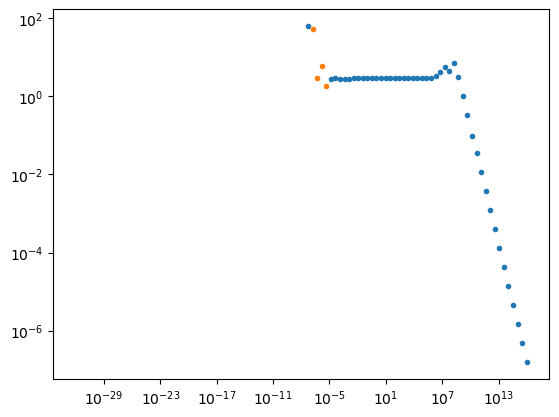

In [161]:
print(drv[0,:])
plt.loglog(dxs, drv[0,:], '.')
plt.loglog(dxs, -drv[0,:], '.')

#plt.plot(dxs, drv[1,:], '.')
#plt.plot(dxs, drv[2,:], '.')

In [108]:
# look at derivative calculation
dxs = np.logspace(-32, 8, 100)
drv = np.zeros((3, 100))

def f(x):
    return 4*(x**2)

x0 = 1
for i,dx in enumerate(dxs): 
    x1 = x0+dx
    df = f(x1)-f(x0)
    drv[0, i] = df

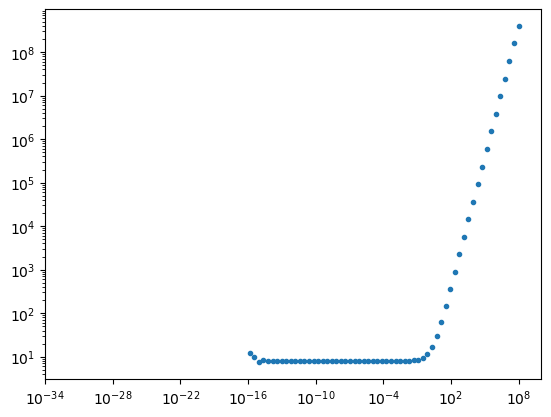

In [109]:
plt.loglog(dxs, drv[0,:]/dxs, '.')


In [159]:
def psiGridSearch(TRACE, sim, tshift, band, dly, dlyBound, steps, plot=False, grid=False, psis=False):
    # Find min/max psi bounds based on delay
    dlyMax = dly + dlyBound
    dlyMin = max(0, dly - dlyBound)

    # McMichael 2017 Table 1
    psi1C = {1: 8.71e-8, 3: 3.04e-8, 4: 1.7e-8, 5: 1.08e-8}
    psi2C = {1: 2.43e-6, 3: 2.83e-7, 4: 8.75e-8, 5: 3.54e-8}
    psi3C = {1: 4.50e-5, 3: 1.69e-6, 4: 2.85e-7, 5: 7.30e-8}
    key = int(band / 1e6)
    psi1Max = dlyMax / psi1C[key]
    psi2Max = dlyMax / psi2C[key]
    psi3Max = dlyMax / psi3C[key]

    # Constrained grid search by dlyBound samples around dly
    # print(psi1Min, psi2Min, psi3Min)
    psi1 = np.linspace(0, psi1Max, steps)
    psi2 = np.linspace(0, psi2Max, steps)
    psi3 = np.linspace(0, psi3Max, steps)

    res = np.zeros((steps, steps, steps))
    for i in range(len(psi1)):
        for j in range(len(psi2)):
            for k in range(len(psi3)):
                delay = totalDelay([psi1[i], psi2[j], psi3[k]], band)
                if np.abs(delay - dly) > dlyBound:
                    res[i, j, k] = 0
                else:
                    res[i, j, k] = obj_func(
                        [psi1[i], psi2[j], psi3[[k]]], TRACE, tshift, band, sim
                    )

    foc = np.where(res == res.min())

    if plot:
        img0 = res[foc[0], :, :]
        img1 = res[:, foc[1], :]
        img2 = res[:, :, foc[2]]
        
        plt.figure()
        plt.pcolormesh(psi3, psi2, np.log(np.abs(img0)).reshape((steps, steps)))
        plt.ylabel("$\psi_2$")
        plt.xlabel("$\psi_3$")
        
        plt.figure()
        plt.pcolormesh(psi3, psi1, np.log(np.abs(img1)).reshape((steps, steps)))
        plt.ylabel("$\psi_1$")
        plt.xlabel("$\psi_3$")
        
        plt.figure()
        plt.pcolormesh(psi2, psi1, np.log(np.abs(img2)).reshape((steps, steps)))
        plt.ylabel("$\psi_1$")
        plt.xlabel("$\psi_2$")
        #for img in [img0, img1, img2]:
        #    plt.figure()

    if(grid and not psis):
        return res
    if(grid and psis):
        return [psi1, psi2, psi3], res
    
    op1 = psi1[foc[0]]
    op2 = psi2[foc[1]]
    op3 = psi3[foc[2]]

    return [op1, op2, op3]


def totalDelay(psis, band):
    # Total delay in samples
    key = int(band / 1e6)
    coeffs = {
        1: [8.71e-8, 2.43e-6, 4.50e-5],
        3: [3.04e-8, 2.83e-7, 1.69e-6],
        4: [1.7e-8, 8.75e-8, 2.85e-7],
        5: [1.08e-8, 3.54e-8, 7.30e-8],
    }
    coeff = coeffs[key]
    return coeff[0] * psis[0] + coeff[1] * psis[1] + coeff[2] * psis[2]


def obj_func(psis, TRACE, ttrig, band, sim):
    # Make sure dims match
    if len(sim.shape) == 1:
        sim = sim[:, np.newaxis]

    pc = pc_phase(psis, TRACE, np.array([ttrig]), band)

    # print(pc.shape, sim.shape)

    num = np.sum((np.abs(pc) ** 2) * (sim ** 2))
    srf = np.argmax(sim)
    denom = np.sum(np.abs(pc[0:srf]) ** 2)

    # plt.plot(np.abs(pc)**2/np.max(np.abs(pc)**2))
    # plt.plot(np.abs(sim)**2/np.max(np.abs(sim)**2))
    # plt.plot((np.abs(pc) ** 2) * (sim ** 2))
    # plt.title(num)

    # plt.show()

    cost = -num/(denom ** 2)

    if False:
        plt.figure()
        plt.plot(np.abs(pc))
        plt.plot(np.abs(sim) * (np.max(np.abs(pc)) / np.max(sim)))
        plt.title(psis)
        plt.figure()
        plt.plot(np.abs(pc[0:srf]))
        plt.title(psis)
        print(psis, num, denom)
    return cost*1e40


def pc_phase(psis, TRACE, dly, band, fs=1.4e6):
    # psis - ionospheric distortion coeffs
    # TRACE - freq domain trace to pulse compress
    # ttrig - trigger time correction
    # f0 - carrier freq
    (psi1, psi2, psi3) = psis
    
    #psi1 *= 1e10
    #psi2 *= 1e10
    #psi3 *= 1e10

    # Reference chirp
    CHIRP = np.fft.fft(refChirp())

    # Shift data to baseband
    TRACE = baseBand(TRACE)

    # Pulse compress
    w = np.fft.fftfreq(len(TRACE), d=1.0 / fs) * 2 * np.pi  # Angular frequency
    f = (np.fft.fftfreq(len(TRACE), d=1.0 / fs) + band) / 1e6  # Frequency in MHz

    c = 299792458  # speed of light m/s
    PHASE = np.exp(
        ((-1j * 2 * np.pi) / c)
        * (
            (((8.98 ** 2) * psi1) / f)
            + (((8.98 ** 4) * psi2) / (3 * (f ** 3)))
            + (((8.98 ** 6) * psi3) / (8 * (f ** 5)))
        )
    )

    PC = pulseCompressTrig(TRACE, CHIRP, dly) * PHASE[:, np.newaxis]

    return np.fft.ifft(PC, axis=0)


def pc_clutter(DATA, sim, ttrig, dcg_config, psis=None):
    findPsis = False
    if psis is None:
        findPsis = True
        psi_t = np.dtype(
            [("psi1", np.float32), ("psi2", np.float32), ("psi3", np.float32)]
        )
        psis = np.empty(DATA.shape[1], dtype=psi_t)

    bands = [1.8e6, 3e6, 4e6, 5e6]
    pc = np.zeros(DATA.shape, dtype=np.float32)
    for i in tqdm(range(DATA.shape[1])):
        band = bands[dcg_config[i]]

        TRACE = DATA[:, i]
        simt = sim[:, i]
        ttrigt = ttrig[i]

        if findPsis:
            if(i == 0):
                x0 = [0,0,0]
            else:
                x0 = list(psis[i-1])
            
            res = scipy.optimize.minimize(obj_func, x0, args=(TRACE, ttrigt, band, simt), method="BFGS", options={disp: True})
            # Grid search ionosphere
            #psi = psiGridSearch(TRACE, simt, ttrigt, band, 0, 256, 5)
            #dly = totalDelay(psi, band)[0]

            #psi = psiGridSearch(TRACE, simt, ttrigt, band, dly, 50, 10)
            #dly = totalDelay(psi, band)[0]

            #psi = psiGridSearch(TRACE, simt, ttrigt, band, dly, 5, 20)
            #dly = totalDelay(psi, band)[0]
                        
            #psi = psiGridSearch(TRACE, simt, ttrigt, band, dly, 1, 40)

            
            
            #print()
            #print("Nit:", res.nit)
            #print("Hess:\n", res.hess_inv.todense())
            #print("Jac:\n", res.jac)
            #print("Psis", res.x)
        
            #print()
            #print("Grid", obj_func(psi, TRACE, ttrigt, band, simt))
            #print("Optim", obj_func(res.x, TRACE, ttrigt, band, simt))

            #dly = totalDelay(psi, band)

            psis[i] = tuple(res.x)

        pc[:, i] = np.abs(pc_phase(psis[i], TRACE, np.array([ttrigt]), band))[:, 0]

    if findPsis:
        return pc, psis
    else:
        return pc
